## Core Image Segmentaion

#### Core Images 

##### Core analysis is the primary method providing precise and measurable insights into the characteristics of oil and gas reservoirs. It forms the foundation for assessing formations, essential in developing both static and dynamic reservoir models. However, there is a significant issue with much of this valuable data being confined within folders and outdated documents. The capacity to liberate this data and integrate it with other seemingly disparate data types is immensely valuable.

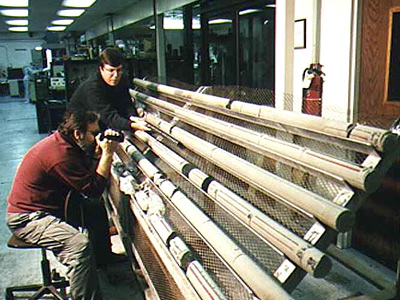

###### Examining Core Samples Source: US Department of Energy, N.E.T.L

### Data Acknowledgement

###### Thank you to EDA and Data Hub for providing the core images 

## Data loading and visualisation 

##### Let's load a core image and have a look:

### Import libraries

In [1]:
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

#### Core image

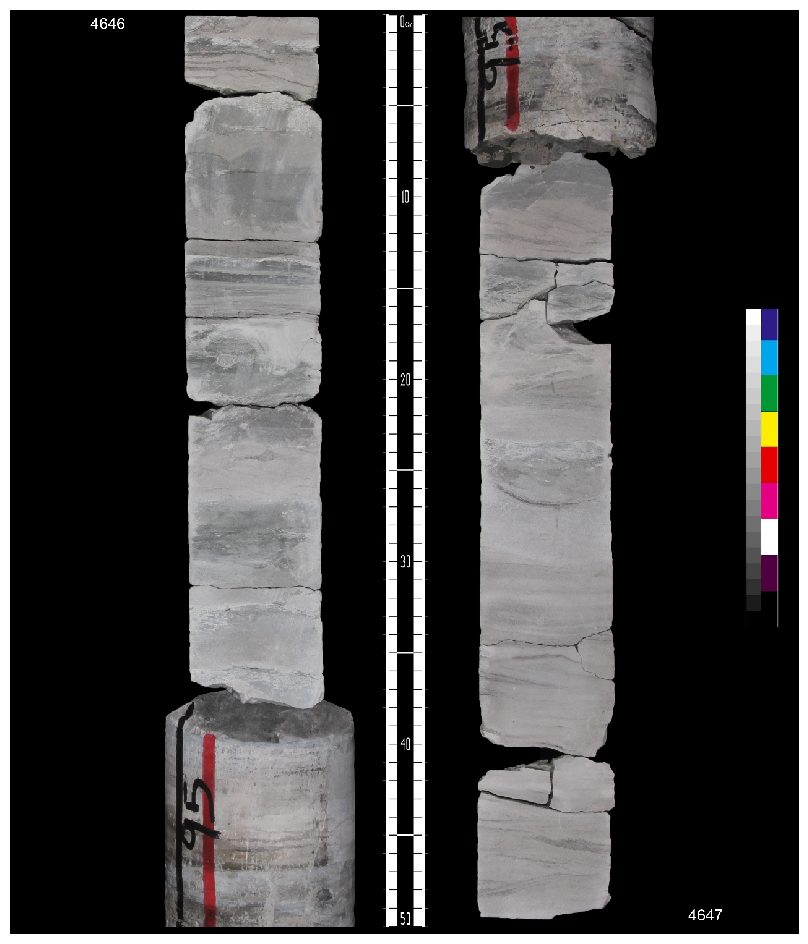

In [2]:
# core_image = Image.open('./image/6d684C41l0f3(1).tif')
core_image = cv2.imread('./image/0r5Cz4q4K0kR.tif')
core_image = cv2.cvtColor(core_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(core_image)
plt.axis('off')  
plt.show()

##### Raw and labeled images serve to emphasize essential features. However, accommodating various formats from different laboratories presents part of our challenge today.

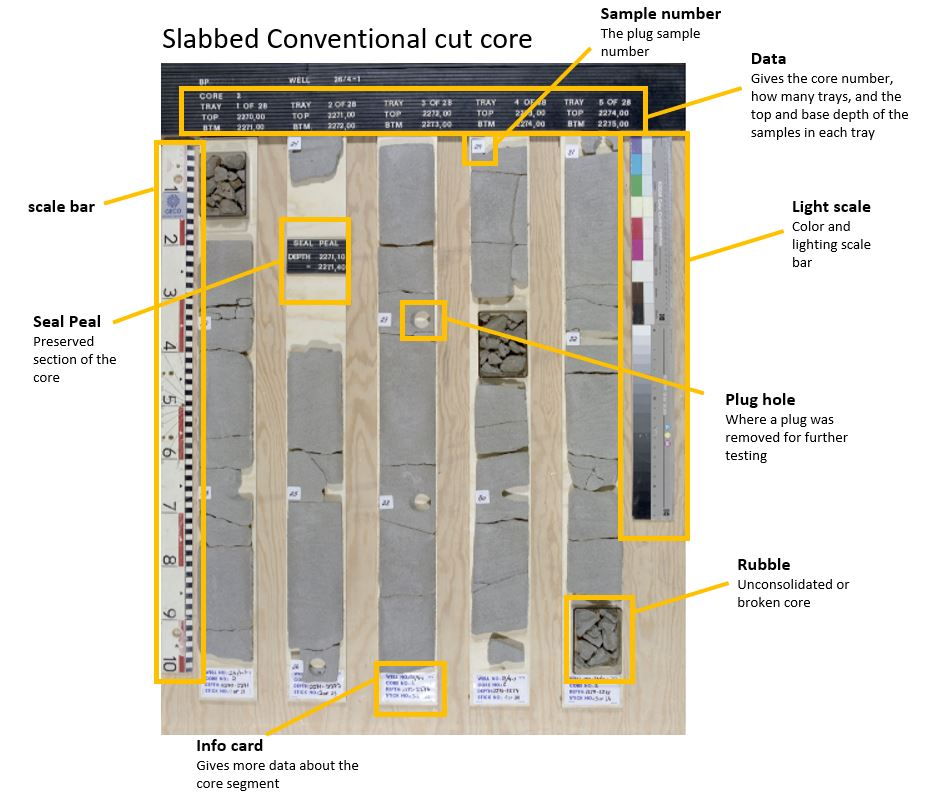

#### Installing the Segment Anything Model (SAM)


In [3]:
# pip install git+https://github.com/facebookresearch/segment-anything.git  #segment anything installation
# pip install opencv-python pycocotools matplotlib onnxruntime onnx # dependancies 

# # or clone the repo with:
# # git clone git@github.com:facebookresearch/segment-anything.git
# # cd segment-anything; pip install -e .

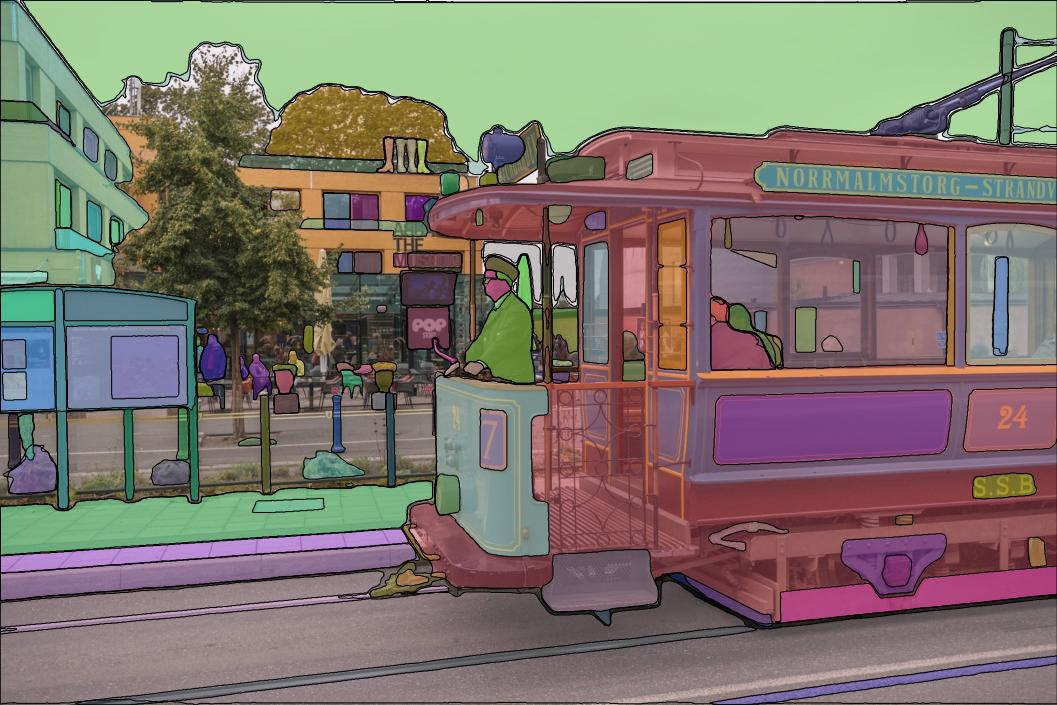

###### The Segment Anything Model (SAM) produces high quality object masks from input prompts such as points or boxes, and it can be used to generate masks for all objects in an image.

### The challenge:

##### Here's the hackathon challenge: __Segment the individual core segments from the images, identify if the images are in normal or UV light, make an assesment of the image quality and capture where plugs have been taken.__ 



### Your turn!

##### There is no rule on how you start this task. We've included some of the installation methods for the Segment Anything Model (SAM) - a model that has been trained on a data set of over 11 million images and 1.1 billion masks. More information abotu this model can be found here:  https://github.com/facebookresearch/segment-anything or here https://segment-anything.com/ but you can use any model for the segmentation. Ask as many questions as you like. We can help with installation and give you more information on core images and geology.

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

mask_generator_default = SamAutomaticMaskGenerator(
    sam, # the sam model
    pred_iou_thresh=0.1,  # set iou threshold
    stability_score_thresh=0.95,  # set stability score threshold
)

# our custom mask generator
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=2,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.1,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=200  # Requires open-cv to run post-processing
)

In [5]:
# core_image_np = np.array(core_image)
core_image_np = core_image
masks = mask_generator.generate(core_image_np)

In [6]:
print(len(masks))
print(masks[0].keys())

# print(core_image_np.shape)
# for mask in masks:
#     print(mask["bbox"])
#     print(mask["segmentation"].shape)

13
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [7]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

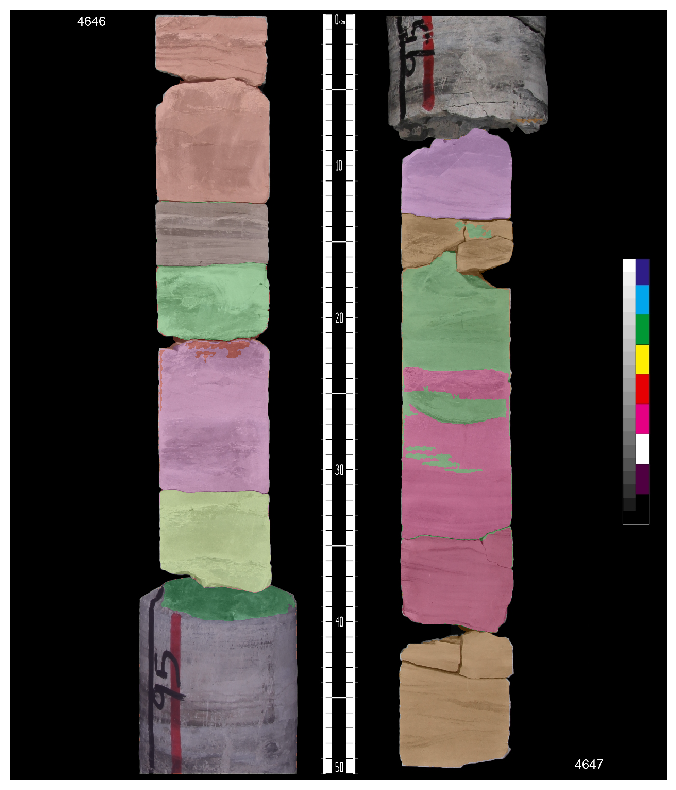

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(core_image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [9]:
masks[2:3]

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 31814,
  'bbox': [759, 230, 214, 177],
  'predicted_iou': 1.0007308721542358,
  'point_coords': [[956.25, 373.75]],
  'stability_score': 0.9916371703147888,
  'crop_box': [0.0, 0.0, 1275.0, 1495.0]}]

In [10]:
from sklearn.cluster import KMeans

# sort masks by area
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
areas = np.array([mask['area'] for mask in masks]).reshape(-1, 1)

# use KMeans to cluster the areas
kmeans = KMeans(n_clusters=3, random_state=0).fit(areas)

# get the labels
labels = kmeans.labels_

# find the average area for each label
label_to_areas = {label: [] for label in labels}
for area, label in zip(areas.flatten(), labels):
    label_to_areas[label].append(area)

# calculate the average area for each label
label_to_avg_area = {label: np.mean(label_to_areas[label]) for label in label_to_areas}

# sort the labels by the average area, the first label is the core
sorted_labels_by_avg_area = sorted(label_to_avg_area, key=label_to_avg_area.get, reverse=True)

# if the first label is as large as the whole image, it may be the background, so we choose the second label
if label_to_avg_area[sorted_labels_by_avg_area[0]] > 0.9 * core_image_np.shape[0] * core_image_np.shape[1]:
    core_label = sorted_labels_by_avg_area[1]
else:
    core_label = sorted_labels_by_avg_area[0]

# get the masks of the core label
core_masks = [mask for mask, label in zip(masks, labels) if label == core_label]

# according to the core label, we can get the core masks, and then we can use the core masks to do the clustering
# first, we need to get the center of the bounding box of each mask using the 'bbox' key
bbox_xy = np.array([mask['bbox'][:2] for mask in core_masks])

# use KMeans to cluster the bbox center to 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(bbox_xy)

# get the labels
bbox_labels = kmeans.labels_

# according to the bbox labels, we can get the final masks
final_masks = []
for label in np.unique(bbox_labels):
    # find all the masks with the same label
    label_masks = [mask for mask, l in zip(core_masks, bbox_labels) if l == label]
    # find the mask with the largest predicted_iou and stability_score
    top_mask = max(label_masks, key=lambda x: (x['predicted_iou'], x['stability_score']))
    final_masks.append(top_mask)

final_masks

/Users/youhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/youhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 341555,
  'bbox': [251, 12, 305, 1470],
  'predicted_iou': 0.9015358090400696,
  'point_coords': [[318.75, 1121.25]],
  'stability_score': 0.8772326707839966,
  'crop_box': [0.0, 0.0, 1275.0, 1495.0]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 249117,
  'bbox': 

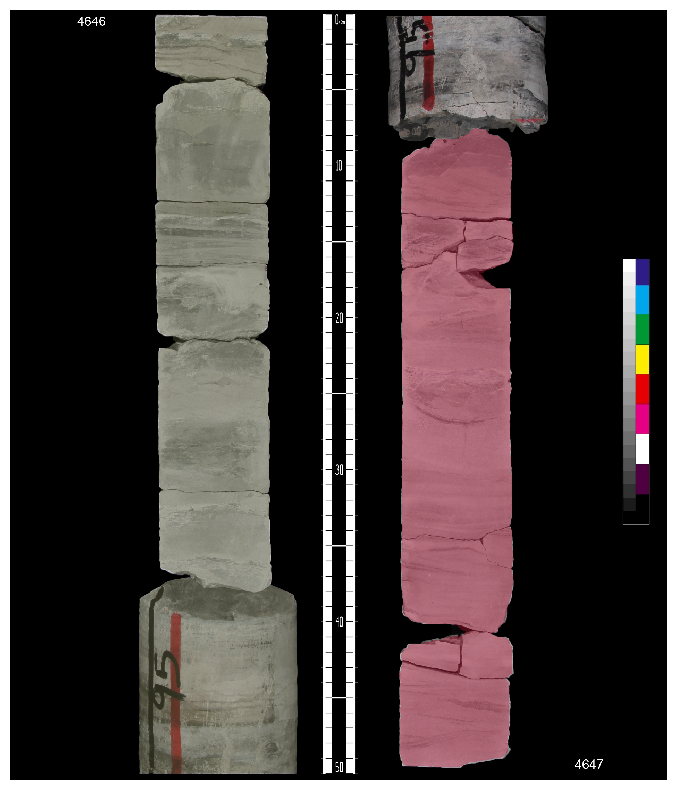

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(core_image)
show_anns(final_masks)
plt.axis('off')
plt.show() 

In [12]:
for i, mask in enumerate(final_masks):
    # transform the mask to uint8 type
    mask_uint8 = (mask["segmentation"] * 255).astype(np.uint8)
    
    # create a 4-channel image with the same shape as the original image, and set the alpha channel to 0
    segmented_img = np.zeros((core_image_np.shape[0], core_image_np.shape[1], 4), dtype=np.uint8)
    
    # use the mask to get the segmented area
    # for alpha channel, 0 means transparent and 255 means not transparent
    segmented_img[mask_uint8 > 0, :3] = core_image_np[mask_uint8 > 0]
    segmented_img[mask_uint8 > 0, 3] = 255  # set the alpha channel to 255
    
    # save the segmented area to a png file
    save_path = f'./data/segmented_area_{i}.png'
    cv2.imwrite(save_path, cv2.cvtColor(segmented_img, cv2.COLOR_RGBA2BGRA))

    print(f'Saved segmented area {i} to {save_path}')

Saved segmented area 0 to ./data/segmented_area_0.png
Saved segmented area 1 to ./data/segmented_area_1.png


In [13]:
import os
def calculate_hsv_means(image_path):
    """compute the mean of the HSV channels of an image"""
    image = cv2.imread(image_path)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h_mean, s_mean, v_mean = cv2.mean(image_hsv)[:3]
    return h_mean, s_mean, v_mean

def process_images(folder_path):
    """process all images in a folder and print the mean of the HSV channels of each image"""
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        h_mean, s_mean, v_mean = calculate_hsv_means(image_path)
        print(f"{image_name}: H mean = {h_mean}, S mean = {s_mean}, V mean = {v_mean}")

uv_folder = './data/uv'  # folder containing the UV images
normal_folder = './data/normal'  # folder containing the normal light images

print("UV Images:")
process_images(uv_folder)

print("\nNormal Light Images:")
process_images(normal_folder)

UV Images:
uv_segmented_area_3.png: H mean = 16.200648233450657, S mean = 30.089305821305683, V mean = 10.285169568264317
uv_segmented_area_2.png: H mean = 17.09895255080749, S mean = 31.439821376546274, V mean = 11.0439462121749
uv_segmented_area_0.png: H mean = 17.929757207666505, S mean = 31.334795308674817, V mean = 10.71122933014142
uv_segmented_area_1.png: H mean = 16.839771837271506, S mean = 29.304487889938084, V mean = 9.837290222793614

Normal Light Images:
normal_segmented_area_3.png: H mean = 10.761392433771341, S mean = 0.6279865264885055, V mean = 21.214603929642713
normal_segmented_area_2.png: H mean = 8.330229219297571, S mean = 0.43501476130467454, V mean = 22.305899197150683
normal_segmented_area_0.png: H mean = 12.335485809899767, S mean = 1.733955520899329, V mean = 30.28299299835924
normal_segmented_area_1.png: H mean = 8.867216563510242, S mean = 0.8676235034195948, V mean = 31.327948080640706


In [14]:
def identify_light_type(image_path):
    """identify the light type of an image based on the mean of the HSV channels"""
    image = cv2.imread(image_path)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h_mean, s_mean, v_mean = cv2.mean(image_hsv)[:3]
    
    # according to the mean of the HSV channels, based on the data we have
    if s_mean < 5 and v_mean > 20:
        return "Normal Light"
    else:
        return "UV Light"

# identify the light type of each image
image_paths = []
for image_name in os.listdir(uv_folder):
    image_paths.append(os.path.join(uv_folder, image_name))
for image_name in os.listdir(normal_folder):
    image_paths.append(os.path.join(normal_folder, image_name))


for image_path in image_paths:
    light_type = identify_light_type(image_path)
    print(f"{image_path}: {light_type}")

./data/uv/uv_segmented_area_3.png: UV Light
./data/uv/uv_segmented_area_2.png: UV Light
./data/uv/uv_segmented_area_0.png: UV Light
./data/uv/uv_segmented_area_1.png: UV Light
./data/normal/normal_segmented_area_3.png: Normal Light
./data/normal/normal_segmented_area_2.png: Normal Light
./data/normal/normal_segmented_area_0.png: Normal Light
./data/normal/normal_segmented_area_1.png: Normal Light


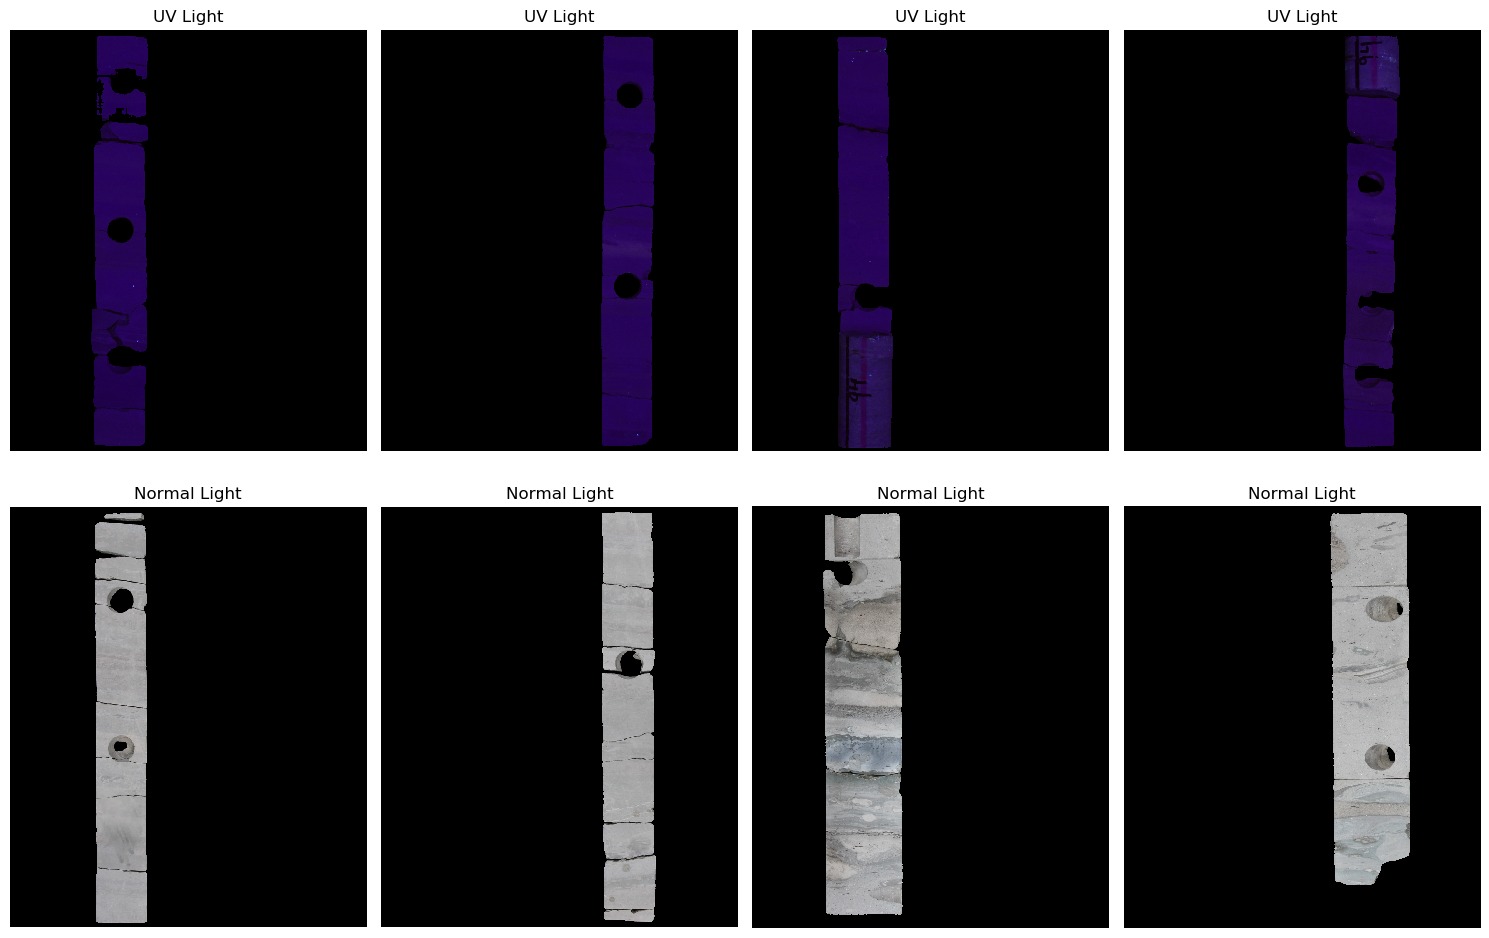

In [15]:
import matplotlib.pyplot as plt

# display the images with their light types
def display_images_with_labels(image_paths):
    num_images = len(image_paths)
    num_cols = 4
    num_rows = num_images // num_cols if num_images % num_cols == 0 else num_images // num_cols + 1

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, image_path in enumerate(image_paths):
        row = i // num_cols
        col = i % num_cols

        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        light_type = identify_light_type(image_path)

        axs[row, col].imshow(image_rgb)
        axs[row, col].set_title(light_type)
        axs[row, col].axis('off')  # 关闭坐标轴

    if num_images % num_cols != 0:
        for col in range(num_images % num_cols, num_cols):
            axs[num_rows - 1, col].axis('off')

    plt.tight_layout()
    plt.show()

display_images_with_labels(image_paths)

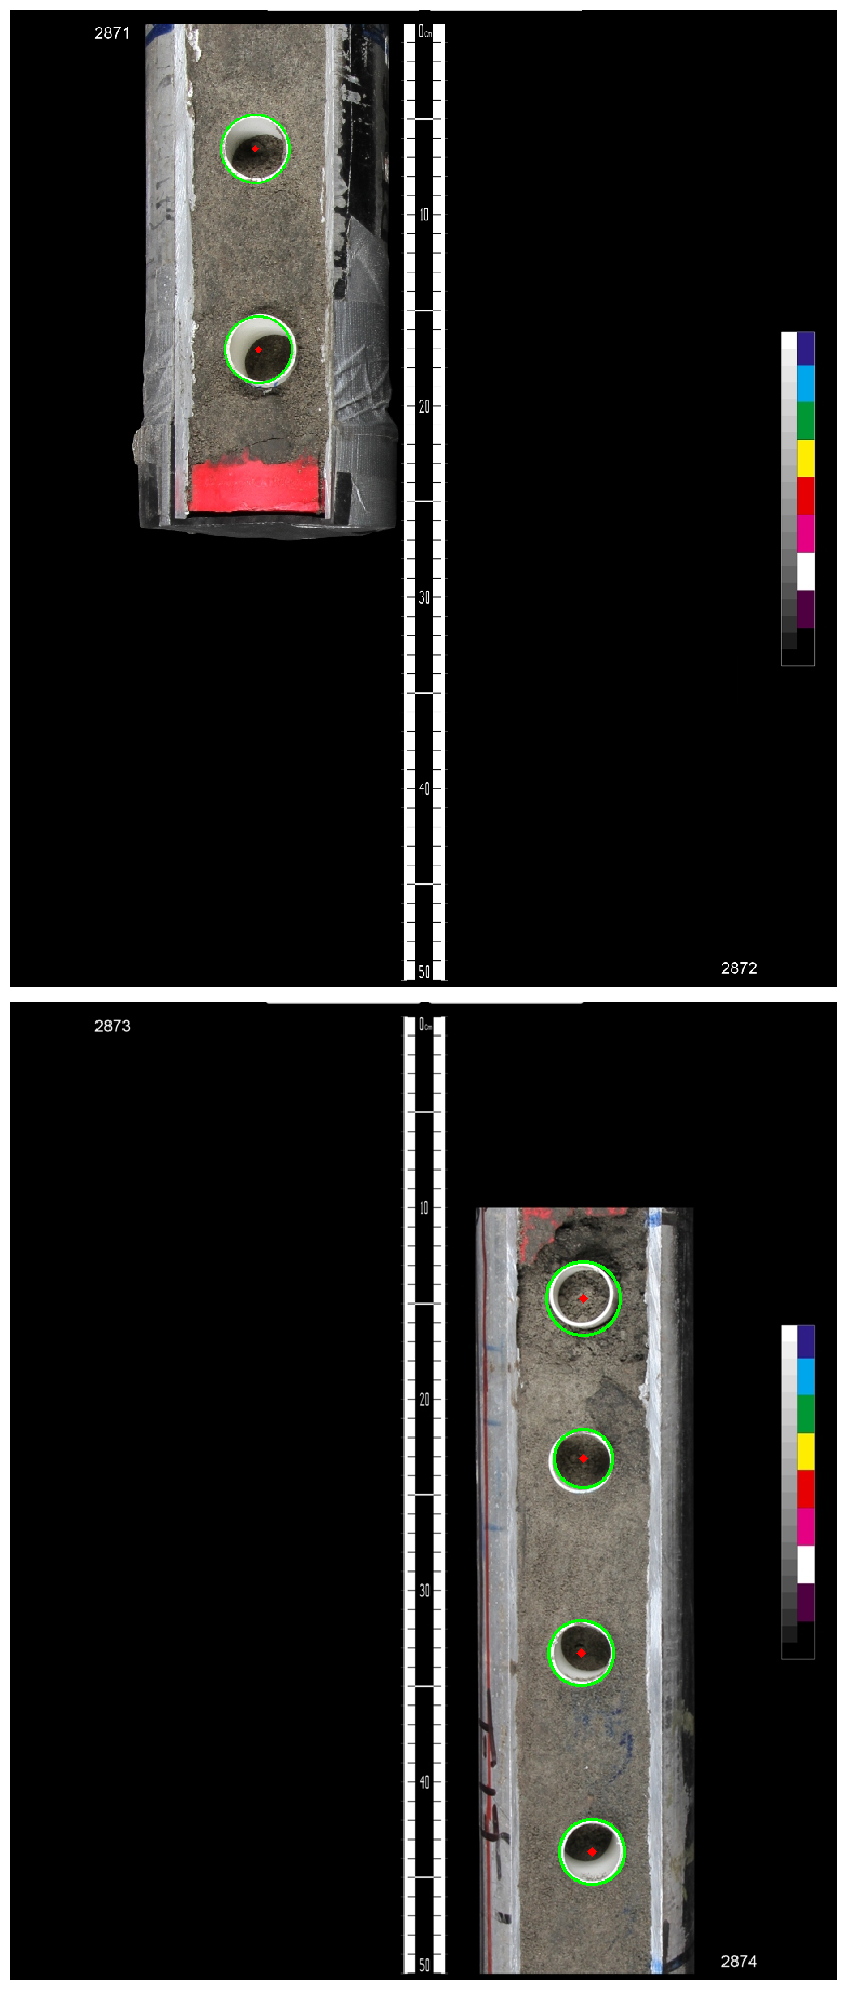

In [16]:
# List of image paths
image_paths = ['./image/1BOC9LcpguSn.tif', './image/2UwhgyUOWtL5.tif']

# Calculate number of rows and columns for subplots
num_images = len(image_paths)
num_cols = 1  # Change this to display multiple images per row
num_rows = num_images // num_cols if num_images % num_cols == 0 else num_images // num_cols + 1

# Create a new figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10 * num_rows))

# Make axs a 2D array even if num_rows is 1
if num_rows == 1:
    axs = np.array([axs])

# Iterate over each image path
for idx, image_path in enumerate(image_paths):
    # Load image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur
    gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # Detect circles
    circles = cv2.HoughCircles(
        gray_blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=40,
        param1=80,
        param2=50,
        minRadius=1,
        maxRadius=150
    )

    # Draw detected circles
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

    # Convert image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate subplot row and column
    row = idx // num_cols
    col = idx % num_cols

    # Display the image in the subplot
    if num_rows == 1 and num_cols == 1:
        axs.imshow(image_rgb)
        axs.axis('off')  # Turn off axis
    elif num_rows == 1 or num_cols == 1:
        axs[max(row, col)].imshow(image_rgb)
        axs[max(row, col)].axis('off')  # Turn off axis
    else:
        axs[row, col].imshow(image_rgb)
        axs[row, col].axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

In [17]:
def calculate_laplacian_variance(image_path):
    """compute the variance of the Laplacian of an image"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    variance = laplacian.var()
    return variance

def process_images(folder_path):
    """process all images in a folder and print the variance of the Laplacian of each image"""
    variances = []
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        variance = calculate_laplacian_variance(image_path)
        variances.append(variance)
        print(f"{image_name}: Laplacian variance = {variance}")
    return variances

low_folder = './data/low'  # folder containing the low quality images
high_folder = './data/high'  # folder containing the high quality images

print("Low Quality Images:")
low_variances = process_images(low_folder)

print("\nHigh Quality Images:")
high_variances = process_images(high_folder)

# may need to further process the images to get the final result


Low Quality Images:
3B2B1lkURIGy.tif: Laplacian variance = 913.9988698089858
2lTZjA7QO7dq.tif: Laplacian variance = 920.4879191473386

High Quality Images:
0r5Cz4q4K0kR.tif: Laplacian variance = 829.1031606006951
1XTgKO8R6oZf.tif: Laplacian variance = 919.9489098694701


In [18]:
# TODO: evaluate_image_quality
# def evaluate_image_quality(image):
#     # transform the image to grayscale
#     image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     # compute the variance of the Laplacian of the image
#     laplacian_var = cv2.Laplacian(image_gray, cv2.CV_64F).var()
    
#     # determine the image quality based on the variance of the Laplacian
#     if laplacian_var > 300:  # may need to adjust the threshold
#         return "High Quality"
#     else:
#         return "Low Quality"

# image_quality = evaluate_image_quality(final_core_image)
# print(f"Image Quality: {image_quality}")

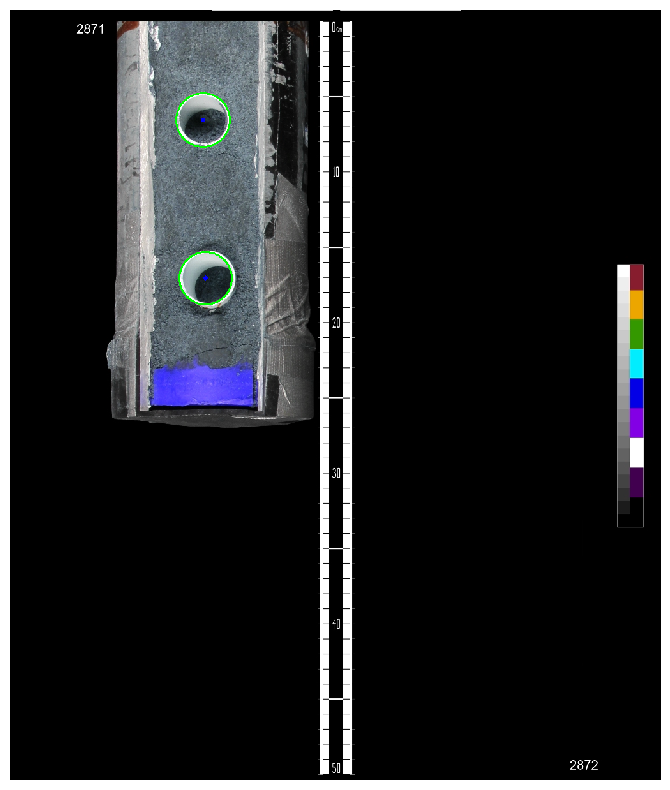

In [19]:
import cv2
import numpy as np

# Load image
image = cv2.imread('./image/1BOC9LcpguSn.tif')  # Update the path to your image file

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur to reduce noise and improve circle detection
gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# HoughCircles function to detect circles
# The parameters can be adjusted to detect circles with different properties
circles = cv2.HoughCircles(
    gray_blurred,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=40,
    param1=80,
    param2=50,
    minRadius=1,
    maxRadius=150
)

# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw the outer circle
        cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Draw the center of the circle
        cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

# Save the output image with detected circles
cv2.imwrite('./data/circled.tif', image)

# Create a new figure with a specific size (in inches)
plt.figure(figsize=(10, 10))

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

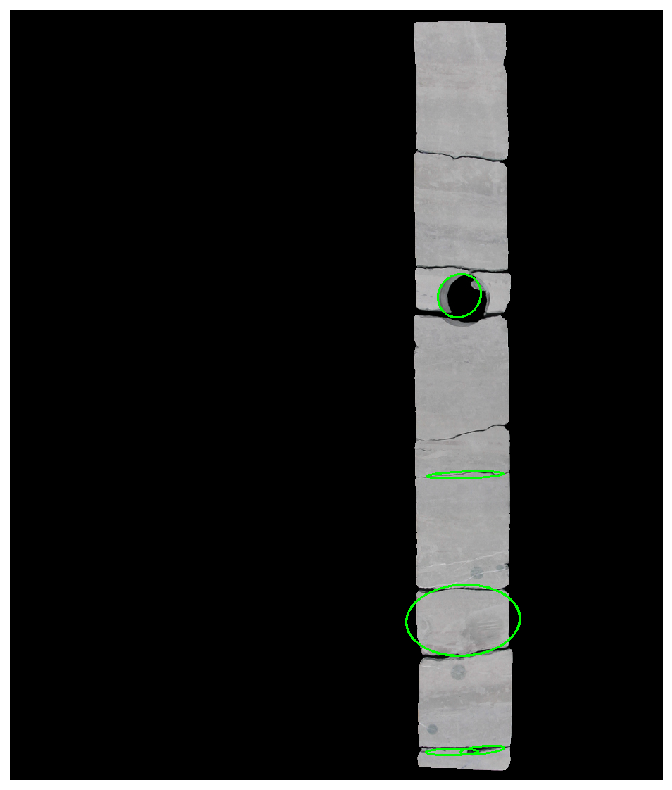

In [20]:
def contour_filter_for_ellipse(contour, min_ellipse_area=500, max_ellipse_area=20000):
    # Check if there are enough points to fit an ellipse
    if len(contour) < 5:
        return False

    # Fit an ellipse to the contour
    ellipse = cv2.fitEllipse(contour)

    # Calculate the area of the ellipse
    ellipse_area = np.pi * (ellipse[1][0] / 2) * (ellipse[1][1] / 2)

    # Check if the ellipse area is within the specified range
    if min_ellipse_area <= ellipse_area <= max_ellipse_area:
        return True
    else:
        return False

# Load image from the uploaded file
image_path = './data/normal/normal_segmented_area_2.png'
image = cv2.imread(image_path)

# Check if image is loaded
if image is None:
    raise ValueError(f"Image at path {image_path} could not be loaded. Please check the path and try again.")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (9,9), 0)

# Edge detection using Canny
edges = cv2.Canny(blurred, 10, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    if contour_filter_for_ellipse(contour):  # Check if the contour fits an ellipse within the size criteria
        ellipse = cv2.fitEllipse(contour)
        cv2.ellipse(image, ellipse, (0, 255, 0), 2)


# Save the result
output_path = './data/ellipse.tif'
cv2.imwrite(output_path, image)

# Create a new figure with a specific size (in inches)
plt.figure(figsize=(10, 10))

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()